# SMT vs Non-SMT Comparison

This notebook demonstrates how to compare SMT-enabled vs non-SMT processor configurations
at the same oversubscription ratio.

**Use Case**: You want to understand the carbon and TCO implications of disabling SMT
on your server fleet while keeping the same oversubscription policy.

In [1]:
import sys
sys.path.insert(0, '..')

from smt_oversub_model import (
    compare_smt_vs_nosmt,
    compare_oversub_ratios,
    ScenarioBuilder,
    plot_scenarios,
)

## Basic Comparison: SMT vs Non-SMT at No Oversubscription

Compare what happens when you disable SMT on your fleet while maintaining R=1.0 (no oversubscription).

In [2]:
# Compare SMT vs Non-SMT at R=1.0 (no oversubscription)
result = compare_smt_vs_nosmt(
    total_vcpus=10000,      # Total vCPU demand
    oversub_ratio=1.0,      # No oversubscription
    avg_util=0.3,           # 30% average utilization
    smt_physical_cores=84,
    nosmt_physical_cores=96,
    smt_power_idle_w=100.0,
    smt_power_max_w=500.0,
    nosmt_power_ratio=1.0,
    nosmt_idle_ratio=1.0,
    smt_core_overhead=8,
    nosmt_core_overhead=9,
    carbon_intensity_g_kwh=200.0,
    embodied_carbon_kg=4000.0,
    server_cost_usd=10000.0,
    electricity_cost_usd_kwh=0.28,
    lifetime_years=6.0,
)
# Some values from /Users/jaylenw/Code/frugal-model/savings_v2.ipynb

# Display results
print("=" * 60)
print("SMT vs Non-SMT Comparison (R=1.0, No Oversubscription)")
print("=" * 60)
print(f"\nWorkload: {result['summary']['total_vcpus']} vCPUs @ {result['summary']['avg_util']:.0%} avg utilization")
print(f"Lifetime: {result['summary']['lifetime_years']:.0f} years\n")

for scenario in result['scenarios']:
    print(f"--- {scenario['name']} ---")
    print(f"  Servers: {scenario['num_servers']}")
    print(f"  Total Carbon: {scenario['total_carbon_kg']:,.0f} kg CO2e")
    print(f"  Total TCO: ${scenario['total_cost_usd']:,.0f}")
    print()

SMT vs Non-SMT Comparison (R=1.0, No Oversubscription)

Workload: 10000 vCPUs @ 30% avg utilization
Lifetime: 6 years

--- SMT ---
  Servers: 63
  Total Carbon: 397,066 kg CO2e
  Total TCO: $833,092

--- Non-SMT ---
  Servers: 115
  Total Carbon: 725,881 kg CO2e
  Total TCO: $1,522,234



## Oversubscription Savings Sweep: Actual vs Theoretical

This analysis shows how carbon and TCO savings scale with oversubscription ratio for SMT.

**Theoretical savings** assume a perfectly linear relationship: if you oversub by R, you need 1/R servers.
- At R=2.0: theoretical = 50% (half the servers)
- At R=1.5: theoretical = 33.3%
- At R=1.2: theoretical = 16.7%

**Actual savings** may differ due to:
- Power consumption doesn't scale linearly with utilization
- Ceiling effects when calculating server counts
- Embodied vs operational carbon mix

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compute_oversub_savings_sweep(
    total_vcpus: int = 10000,
    avg_util: float = 0.3,
    oversub_min: float = 1.0,
    oversub_max: float = 2.0,
    step: float = 0.1,
    util_overhead: float = 0.0,
    smt: bool = True,
    **kwargs,
):
    """
    Compute actual and theoretical savings for a sweep of oversubscription ratios.
    
    Returns:
        dict with 'ratios', 'carbon_savings_pct', 'tco_savings_pct', 'theoretical_savings_pct'
    """
    ratios = np.arange(oversub_min, oversub_max + step/2, step)
    
    # Create builder
    builder = ScenarioBuilder()
    workload = builder.build_workload_params(total_vcpus, avg_util)
    cost = builder.build_cost_params(**kwargs)
    
    # Get baseline (R=1.0)
    baseline_scenario = builder.build_scenario(
        name="Baseline",
        smt=smt,
        oversub_ratio=1.0,
        util_overhead=0.0,  # No overhead at baseline
    )
    from smt_oversub_model.analysis import evaluate_scenarios
    baseline_result = evaluate_scenarios([baseline_scenario], workload, cost)[0]
    
    baseline_carbon = baseline_result['total_carbon_kg']
    baseline_tco = baseline_result['total_cost_usd']
    
    # Compute savings for each ratio
    carbon_savings = []
    tco_savings = []
    theoretical_savings = []
    
    for r in ratios:
        # Theoretical: 1 - 1/R (perfect linear server reduction)
        theoretical = (1 - 1/r) * 100
        theoretical_savings.append(theoretical)
        
        # Actual
        scenario = builder.build_scenario(
            name=f"R={r:.1f}",
            smt=smt,
            oversub_ratio=r,
            util_overhead=util_overhead if r > 1.0 else 0.0,
        )
        result = evaluate_scenarios([scenario], workload, cost)[0]
        
        carbon_pct = (1 - result['total_carbon_kg'] / baseline_carbon) * 100
        tco_pct = (1 - result['total_cost_usd'] / baseline_tco) * 100
        
        carbon_savings.append(carbon_pct)
        tco_savings.append(tco_pct)
    
    return {
        'ratios': ratios,
        'carbon_savings_pct': np.array(carbon_savings),
        'tco_savings_pct': np.array(tco_savings),
        'theoretical_savings_pct': np.array(theoretical_savings),
    }

In [8]:
def plot_oversub_savings_sweep(sweep_result, title_suffix=""):
    """
    Plot carbon and TCO savings vs oversubscription ratio.
    
    Creates two side-by-side plots showing actual vs theoretical savings.
    """
    ratios = sweep_result['ratios']
    carbon = sweep_result['carbon_savings_pct']
    tco = sweep_result['tco_savings_pct']
    theoretical = sweep_result['theoretical_savings_pct']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Carbon savings plot
    ax1 = axes[0]
    ax1.plot(ratios, carbon, 'b-o', linewidth=2, markersize=6, label='Actual Carbon Savings')
    ax1.plot(ratios, theoretical, 'k--', linewidth=2, alpha=0.7, label='Theoretical (1 - 1/R)')
    ax1.set_xlabel('Oversubscription Ratio (R)', fontsize=12)
    ax1.set_ylabel('Carbon Savings (%)', fontsize=12)
    ax1.set_title(f'Carbon Savings vs Oversubscription{title_suffix}', fontsize=14)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(ratios[0], ratios[-1])
    ax1.set_ylim(bottom=0)
    
    # TCO savings plot
    ax2 = axes[1]
    ax2.plot(ratios, tco, 'g-o', linewidth=2, markersize=6, label='Actual TCO Savings')
    ax2.plot(ratios, theoretical, 'k--', linewidth=2, alpha=0.7, label='Theoretical (1 - 1/R)')
    ax2.set_xlabel('Oversubscription Ratio (R)', fontsize=12)
    ax2.set_ylabel('TCO Savings (%)', fontsize=12)
    ax2.set_title(f'TCO Savings vs Oversubscription{title_suffix}', fontsize=14)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(ratios[0], ratios[-1])
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [9]:
# Run the sweep with default parameters (SMT, no utilization overhead)
sweep = compute_oversub_savings_sweep(
    total_vcpus=10000,
    avg_util=0.3,
    oversub_min=1.0,
    oversub_max=2.0,
    step=0.1,
    util_overhead=0.0,  # No additional overhead
    smt=True,
)

# Print the data
print("Oversubscription Savings Analysis (SMT)")
print("=" * 60)
print(f"{'Ratio':<8} {'Carbon %':<12} {'TCO %':<12} {'Theoretical %':<12}")
print("-" * 60)
for i, r in enumerate(sweep['ratios']):
    print(f"{r:<8.1f} {sweep['carbon_savings_pct'][i]:<12.1f} {sweep['tco_savings_pct'][i]:<12.1f} {sweep['theoretical_savings_pct'][i]:<12.1f}")

Oversubscription Savings Analysis (SMT)
Ratio    Carbon %     TCO %        Theoretical %
------------------------------------------------------------
1.0      0.0          0.0          0.0         
1.1      6.1          9.2          9.1         
1.2      10.9         16.5         16.7        
1.3      14.6         22.0         23.1        
1.4      18.2         27.5         28.6        
1.5      21.3         32.1         33.3        
1.6      23.7         35.8         37.5        
1.7      26.1         39.5         41.2        
1.8      28.5         43.1         44.4        
1.9      30.4         45.9         47.4        
2.0      31.6         47.7         50.0        


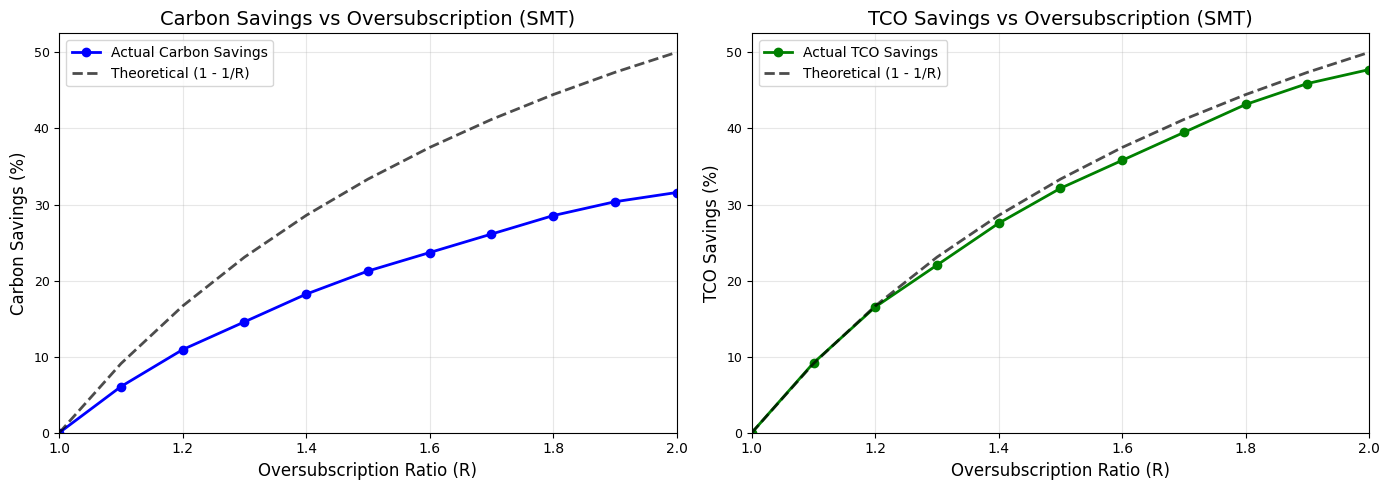

In [15]:
# Plot the results
fig = plot_oversub_savings_sweep(sweep, " (SMT)")